In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import os 
import cv2
from datetime import datetime
import keras
import random
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D,Bidirectional
from keras.layers import AveragePooling2D, Flatten, Activation
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import add,concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Letters present in the Label Text
letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [3]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(letters[ele])
    return "".join(txt)

In [4]:
#https://keras.io/examples/image_ocr/
#https://github.com/qjadud1994/CRNN-Keras
def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 48, 37)
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

In [33]:
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(letters)+1
batch_size=64
max_length=15 # considering max length of ground truths labels to be 15

In [46]:
def model_create(drop_out_rate=0.35):
    """
    Builds the model which takes input as images which is used for prediction and returns the Output Matrix 
    of of dimesnions 48x37 where 48 is the number of time-steps of RNN and 37 is the length of letters 
    + 1 character for ctc blank
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer 
    
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    
    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    
    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    
    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    
    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    return Model(inputs=[model_input], outputs=y_pred)

In [47]:
def test_data_single_image_Prediction(model,test_img_path):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and prints the Predicted Text Label, Time Taken for Computation
    """
    start=datetime.now()
    
    test_img=cv2.imread(test_img_path)
    test_img_resized=cv2.resize(test_img,(170,32))
    test_image=test_img_resized[:,:,1]
    test_image=test_image.T 
    test_image=np.expand_dims(test_image,axis=-1)
    test_image=np.expand_dims(test_image, axis=0)
    test_image=test_image/255
    model_output=model.predict(test_image)
    predicted_output=decode_label(model_output)
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ",datetime.now()-start)  

In [48]:
def test_data_multiple_image_Prediction(model,test_img_names,test_labels,total):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and compares with ground truth text for the input and ouputs the final accuracy,
    letter accuracy and  letter count across the entire test set of images
    """
    start=datetime.now()
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    for i in range(len(test_labels)):
        test_img=cv2.imread(test_img_names[i])
        test_img_resized=cv2.resize(test_img,(170,32))
        test_image=test_img_resized[:,:,1]
        test_image=test_image.T
        test_image=np.expand_dims(test_image,axis=-1)
        test_image=np.expand_dims(test_image, axis=0)
        test_image=test_image/255
        model_output=model.predict(test_image)
        predicted_output=decode_label(model_output)
        actual_output=test_labels[i]
        count+=1
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        if actual_output==predicted_output:
            accuracy+=1
        print("-"*80)
        print("Actual Text: ",actual_output,"   Predicted Text: ",predicted_output)
    print("="*80)
    print("Model Output Accuracy: ",(accuracy/total)*100, " %")
    print("Model Output Letter Accuracy: ",(letter_acc/letter_cnt)*100, " %")
    print("Time Taken for Processing: ",datetime.now()-start)

In [49]:
model=model_create()

ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [825, 159, 512], output_shape = [42, 1024]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 825, 159, 512), dtype=float32)

In [ ]:
model.summary()

In [29]:
model.load_weights('C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR/Best_Img_recog_LSTM_Adam_model_run_weights.h5')

In [30]:
test_image_1='C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\Scanned_images\\Loss Runs\\Page_1.jpg'

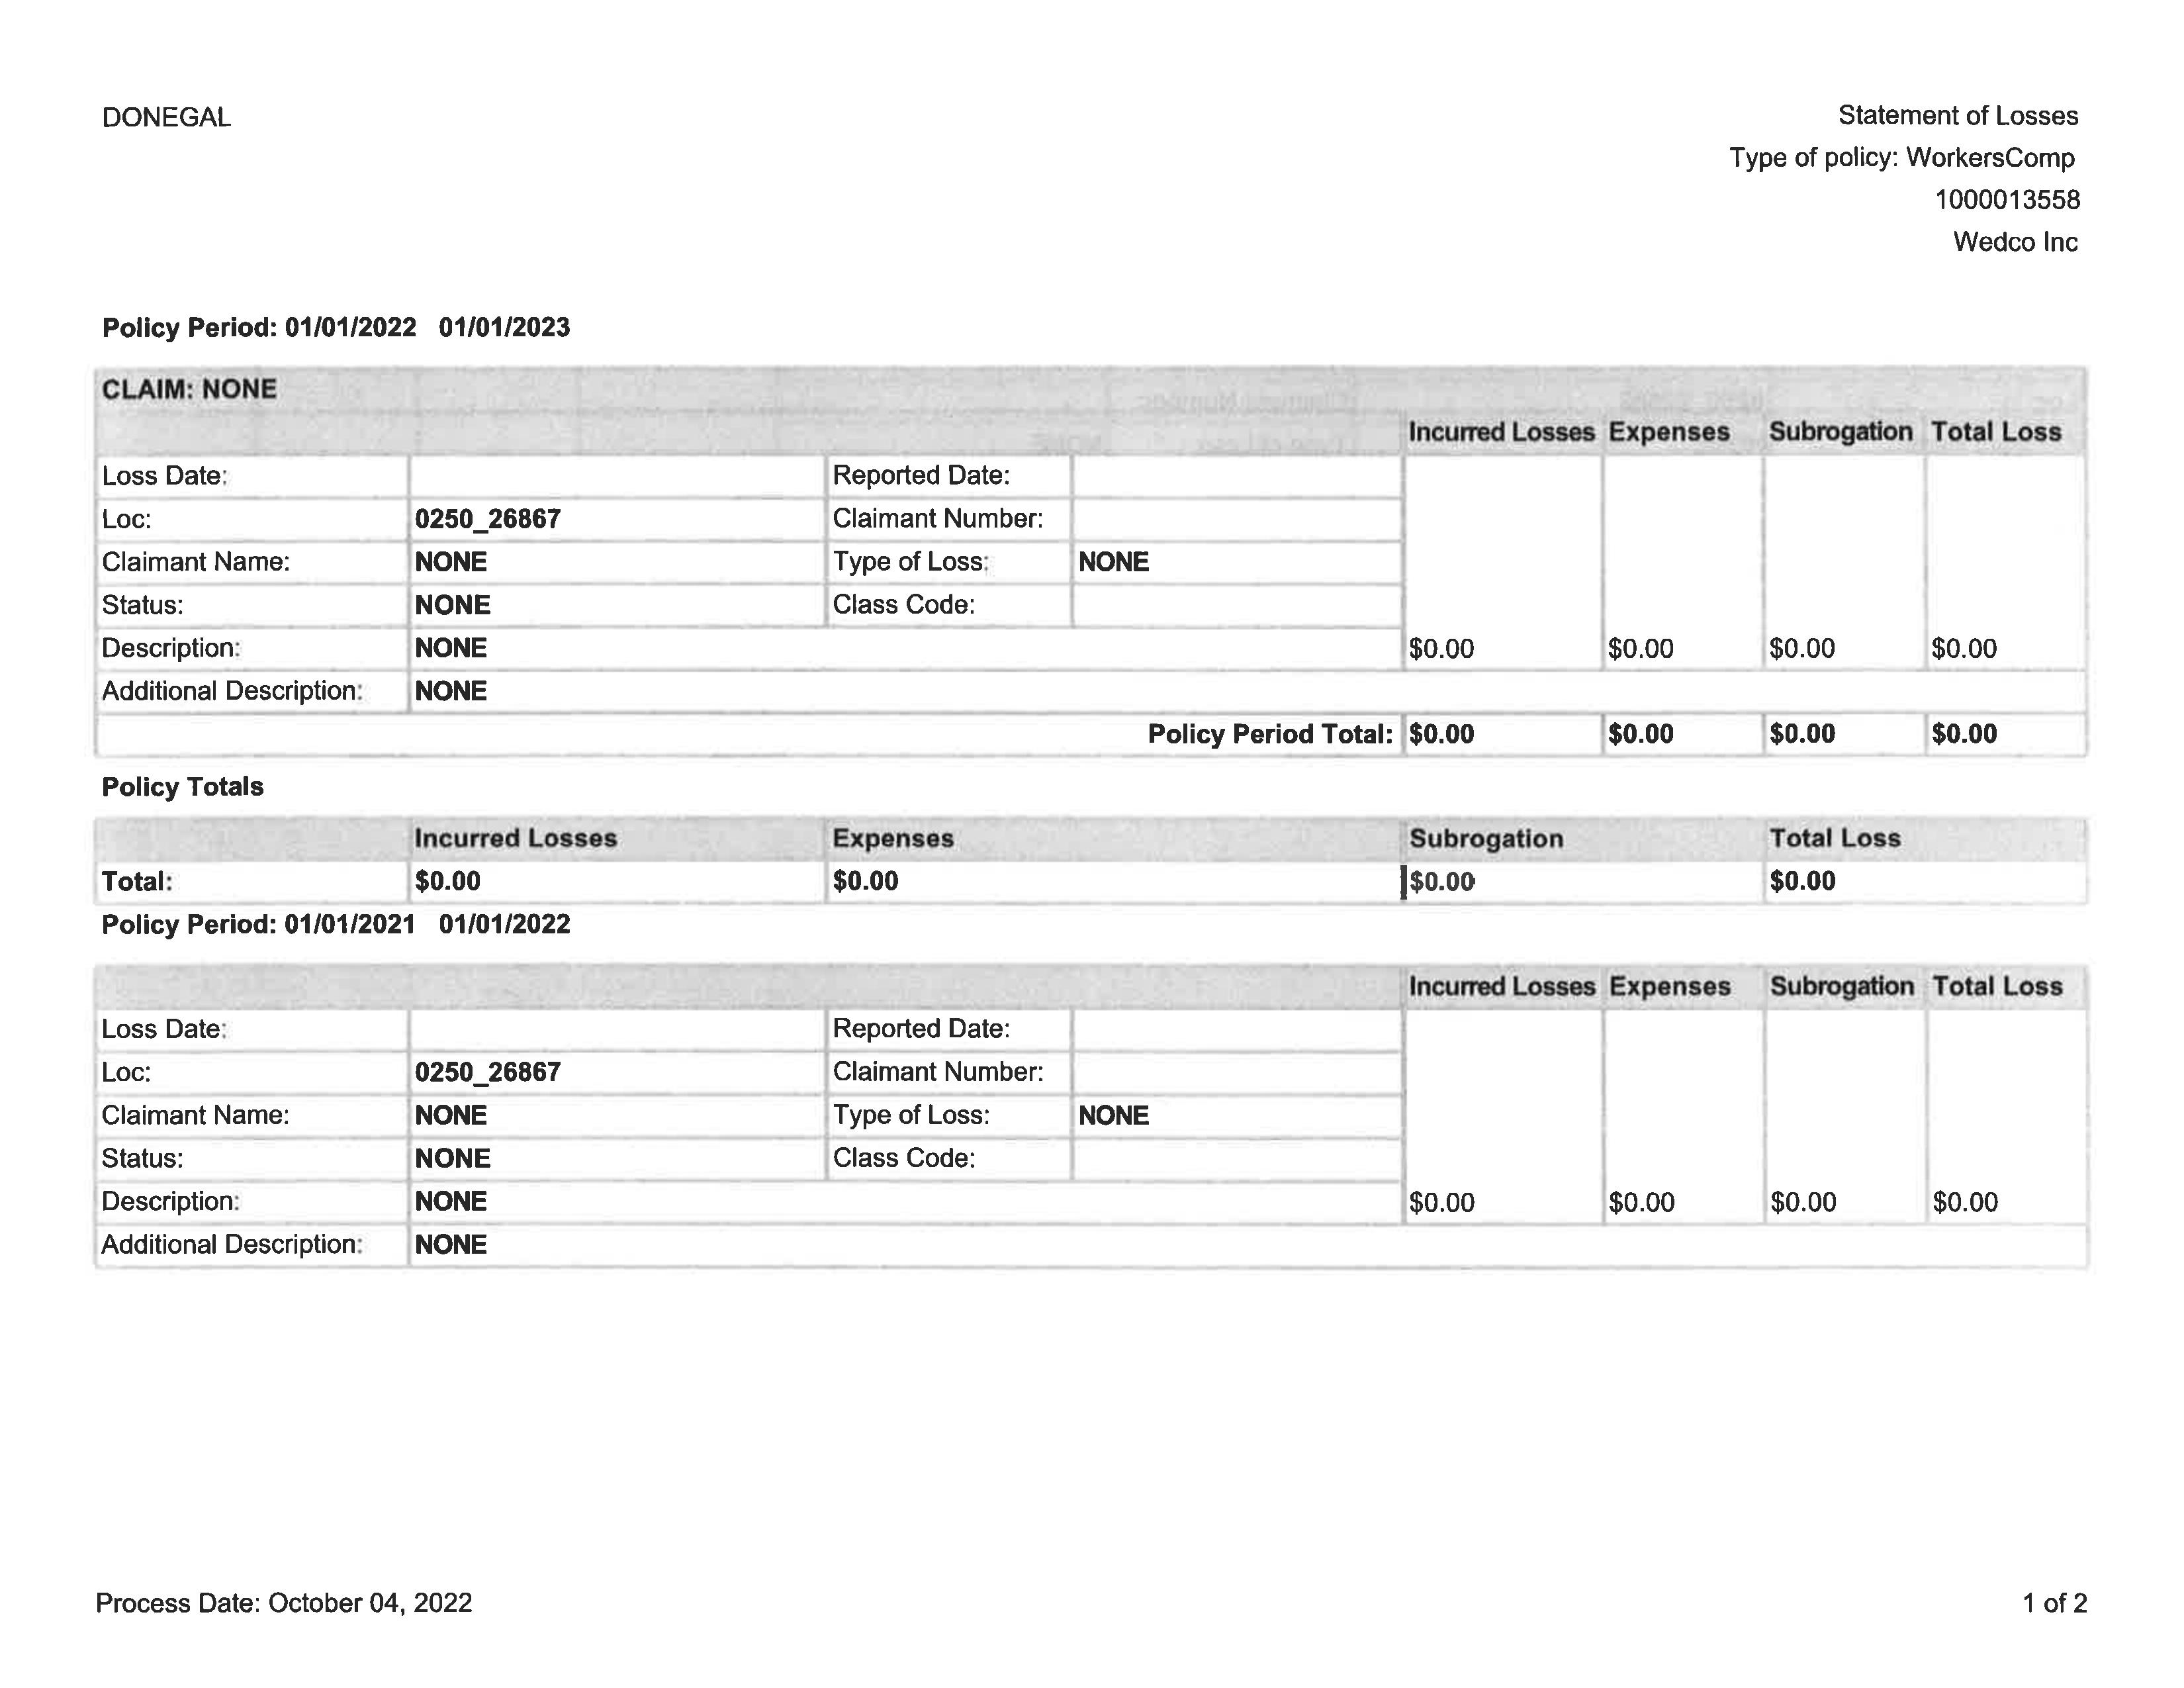

In [31]:
Image(test_image_1)

In [32]:
test_data_single_image_Prediction(model,test_image_1)

ValueError: in user code:

    File "C:\Users\AkshayPatil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\AkshayPatil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\AkshayPatil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\AkshayPatil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\AkshayPatil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\AkshayPatil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 170, 32, 1), found shape=(None, 3300, 2550, 1)
